# COGS 108 - Final Project 

# Overview

Personally, an ideal park would have food sources nearby so I wanted to see if a park's availability to food nearby would have any relationship to its rating. I decided to factor in the average ratings of the restaurants, number of restaurants nearby, and average price range of the restaurants for my analysis. I used the given data about park ratings and also requested additional information using the Yelp API about nearby restaurant data. I compared the park ratings to the average ratings of the restaurants and the average price range of the restaurants as well. After my analysis, I was able to conclude that there is no correlation between park rating and the ratings of its nearby restaurants.

# Name & GitHub ID

- Name: Angel Obie
- GitHub Username: Acobie

# Research Question

Is there a relationship between the quality or quantity of the restaurants nearest to a park in San Diego County and its rating on Yelp? More specifically, if the number of highly-rated restaurants near a park increases, will that also increase the average rating of a park?

## Background and Prior Work

After a long day in the park, one of my first instincts is to find a place to eat and regain some energy. Some might even go find a place to eat first and take their food to eat at the park. 

There has been a study done on whether 'local consumption amenities' (also known as bars, restaurants, and other retail establishments) increases value of a community [1]. Specifically, the researcher was able to conclude that quality of these amenities affect housing prices; 'quality' establishments will increase the housing prices nearby. This study even used Yelp data to grab ratings of the restaurants and bars and compared it against prices of houses in the community, similarly to how I approach my own project here. As a result of reading this article, I believe that the quality of the restaurants will also affect the ratings and perception of parks, not just housing prices.

Additionally, another study was done to determine how to increase park visitation among adolescents [2]. According to the study, adolescents are among the lowest demographic in park visitation, prompting health concerns for this group within the researchers. Thus, they aimed to host a study to determine what features of a park would increase attendance and concluded 'physically challenging play equipment' like steep slides and table tennis tables, would be most beneficial for future park designs according to their survey on their target demographic. Unfortunately, food availability wasn't a feature asked in the survey (possibly because they wanted to improve the health of their audience and asking about more reliable food access might be counterintuitive), but it was nonetheless informative to realize some other cofounding factors like living distance from a park and its ammenities can improve the rating of a park using a different perspective.

References (include links):
- [1] https://www.sciencedirect.com/science/article/abs/pii/S0094119017300219
- [2] https://link.springer.com/article/10.1186/s12966-016-0391-9

# Hypothesis


I believe that there is a positive correlation between park ratings and the number of quality/ highly-rated restaurants nearby across San Diego County. The reliable access to food will increase the attendance of parks and can be viewed as a beneficial feature that can improve a park's value, thus improving its rating on Yelp. 

# Dataset(s)

- Dataset Name: San Diego Parks Yelp Data
- Link to the dataset: https://github.com/COGS108/individual_fa20/blob/master/data/yelp_SD_parks.csv
- Number of observations: 833
- Description: This dataset contains info for all parks in San Diego County from Yelp, such as park name, rating, address, coordinates, and review counts.
<br>
<br>
- Dataset Name: San Diego Restaurants Yelp Data
- Link to the dataset: https://www.yelp.com/developers/documentation/v3/business_search
- Number of observations: 9104
- Description: This dataset contains info for restaurants near parks (500m radius from the park, which should be walking distance) in San Diego County from Yelp, such as rating, price range, and address. This dataset was requested through the Yelp API from the link used. 

The 'San Diego Restaurants Yelp Data' dataset will pull up to 20 restaurants nearest to each park from the 'San Diego Parks Yelp Data' dataset by using the address for each park as an input for the API/ second dataset. From the restaurants list from the resulting query to the API, I will take the average of the ratings and average price range and append it to the park data.
If you plan to use multiple datasets, add 1-2 sentences about how you plan to combine these datasets.

# Setup

In [1]:
import pandas as pd
import requests
import numpy as np
import seaborn as sns
sns.set()
sns.set_context('talk')
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Removed for security reasons. Please enter your own to run this program
api_key = ''

# Data Cleaning

Loading the first dataset into a DataFrame (San Diego Parks Yelp Data)

In [2]:
park_df = pd.read_csv('yelp_SD_parks.csv')

## Cleaning the first dataset
I will only use the park name and address for this study so I will remove the unnecessary columns here.

In [3]:
# Removing phone, id, url, review_count, longitude, latitude, and is_closed columns
park_df.drop(columns = ['phone', 'id', 'url', 'review_count', 'longitude', 'latitude', 'is_closed'], inplace=True)

# View the new dataframe!
park_df

,name,address,rating
0,Balboa Park,"1549 El Prado San Diego, CA 92101",5.0
1,Civita Park,"7960 Civita Blvd San Diego, CA 92108",4.5
2,Waterfront Park,"1600 Pacific Hwy San Diego, CA 92101",4.5
3,Trolley Barn Park,"Adams Ave And Florida St San Diego, CA 92116",4.5
4,Bay View Park,"413 1st St Coronado, CA 92118",5.0
...,...,...,...
828,Del Cerro - San Diego,"San Diego, CA 92120",4.5
829,San Diego Metropolitan Transit System,"1255 Imperial Ave Ste 1000 San Diego, CA 92101",2.5
830,Petco Park,"100 Park Blvd San Diego, CA 92101",4.0
831,Ann D. L'Heureux Memorial Dog Park,"2700 Carlsbad Village Dr Carlsbad, CA 92008",3.0


## A quick look at our current data

Looks like the rating of parks in San Diego is skewed left, with a lot of parks in the 4.0+ rating. Makes sense to me so far since San Diego has REALLY good food. :)

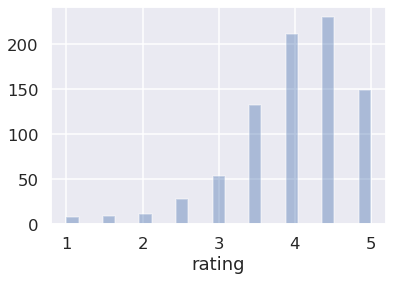

In [4]:
sns.distplot(park_df['rating'], kde=False, bins=25)

global total_obs

## Creating the second 'dataset'

This dataset is never formally created into a dataframe because I automatically calculate and add the needed information to the first dataframe with the data from the first dataset on 'San Diego Parks Yelp Data'. 

In [5]:
# Helper method to request restaurant info to the API
def avg_food_rating(park): 
    
    # Build the request to the Yelp API for 'food' places near a park within 500m. Order the result by distance
    URL = 'https://api.yelp.com/v3/businesses/search'
    Params = {'term' : 'food', 
                'location' : park,
                'radius' : '500',
                'sort_by' : 'distance'
             }
    Headers = {'Authorization' : 'bearer %s' % api_key}
    result = requests.get(url = URL, params = Params, headers = Headers).json()
    
    # Variables to return in the list
    avg_rating = 0
    avg_price = 0
    num_restaurants = 0
    
    # If the park has restaurants within 500m
    if 'businesses' in result: 
        
        # Find the price range and rating for each restaurant
        for x in range(len(result['businesses'])):
            
            # Skip if price data is not available
            if 'price' not in result['businesses'][x]:
                continue
            
            num_restaurants += 1
            
            # Total the ratings of restaurants
            avg_rating += result['businesses'][x]['rating']

            # Total the price range of the restaurants, where '$' is cheapest and '$$$$' is most expensive
            avg_price += len(result['businesses'][x]['price'])
            
        # Calculate the averages 
        if num_restaurants > 0:    
            avg_rating = round(float(avg_rating / num_restaurants), 2)
            avg_price = round(float(avg_price / num_restaurants), 2)
    
    # Return a list of the info calculated for dataset 
    return([num_restaurants, avg_rating, avg_price])

In [6]:
park_df['Food Info'] = park_df['address'].apply(avg_food_rating)

## Cleaning the second 'dataset'

We should split up the list we created in 'Food Info' into separate columns for better clarity.

In [7]:
# Split the list into these three new columns for num_restaurants, avg_restaurant_rating, avg_price_range
park_df[['num_restaurants', 'avg_restaurant_rating', 'avg_price_range',]] = pd.DataFrame(park_df['Food Info'].tolist(), index=park_df.index)

# Drop the original column
park_df.drop(columns = ['Food Info'], inplace=True)

# Check the new dataframe
park_df

,name,address,rating,num_restaurants,avg_restaurant_rating,avg_price_range
0,Balboa Park,"1549 El Prado San Diego, CA 92101",5.0,16,3.31,1.50
1,Civita Park,"7960 Civita Blvd San Diego, CA 92108",4.5,13,3.92,1.38
2,Waterfront Park,"1600 Pacific Hwy San Diego, CA 92101",4.5,11,3.77,1.73
3,Trolley Barn Park,"Adams Ave And Florida St San Diego, CA 92116",4.5,17,4.18,1.59
4,Bay View Park,"413 1st St Coronado, CA 92118",5.0,1,3.50,2.00
...,...,...,...,...,...,...
828,Del Cerro - San Diego,"San Diego, CA 92120",4.5,0,0.00,0.00
829,San Diego Metropolitan Transit System,"1255 Imperial Ave Ste 1000 San Diego, CA 92101",2.5,14,3.39,1.79
830,Petco Park,"100 Park Blvd San Diego, CA 92101",4.0,13,3.50,1.77
831,Ann D. L'Heureux Memorial Dog Park,"2700 Carlsbad Village Dr Carlsbad, CA 92008",3.0,0,0.00,0.00


# Data Analysis & Results

First, lets create a best-fitting line to plot against our results of park ratings against average restaurant ratings.

In [8]:
a1, b1 = np.polyfit(park_df['rating'],park_df['avg_restaurant_rating'],1)
ratings = np.arange(0,5.5,0.5)
pred_rating = a1 * ratings + b1

Text(0.5, 1.0, 'Park Rating vs. Average Nearby Restaurant Rating')

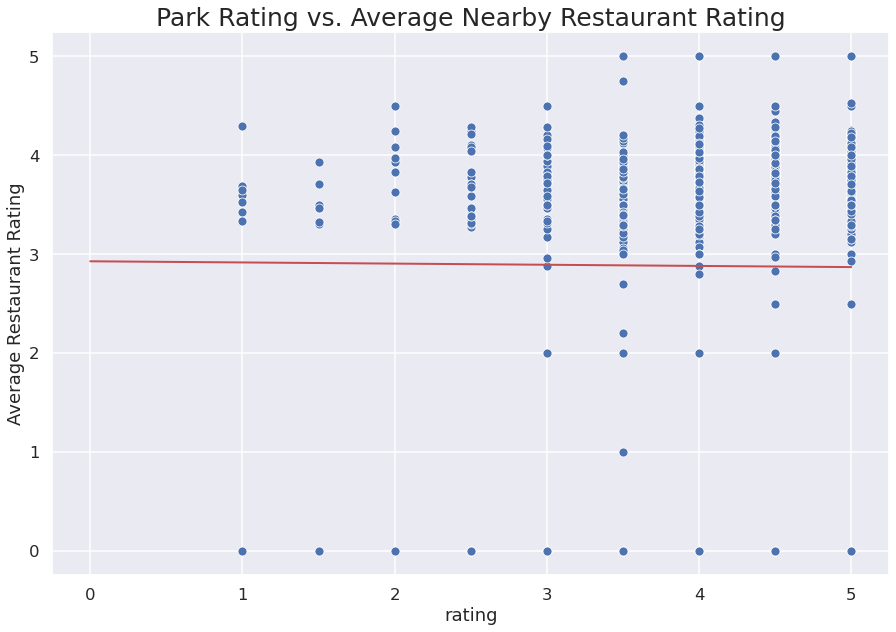

In [9]:
fig, ax = plt.subplots(figsize=(15,10))

ax = sns.scatterplot(park_df['rating'], park_df['avg_restaurant_rating'])
plt.plot(ratings, pred_rating, 'r-', linewidth=2)
#plt.xlabel('Park Rating')
plt.ylabel('Average Restaurant Rating')
plt.title('Park Rating vs. Average Nearby Restaurant Rating', fontsize = 25)

From the plot, it doesn't look like there's any relationship at all between park ratings and average restaurant ratings. 
<br>
To be sure, I'll check the Pearson r correlation.

In [10]:
print('Pearson r-value: ', pearsonr(park_df['avg_restaurant_rating'],park_df['rating'])[0])

Pearson r-value:  -0.005795271232010835


With an r-value that small, there's hardly any correlation at all! 
<br>
<br>
Now let's check the ratings of parks against the average price range of nearby restaurants. 
<br>
Again, I'll start by creating the best-fitting line.

In [11]:
a2, b2 = np.polyfit(park_df['rating'],park_df['avg_price_range'],1)
pred_rating2 = a2 * ratings + b2

Text(0.5, 1.0, 'Park Rating vs. Average Nearby Restaurant Price Range')

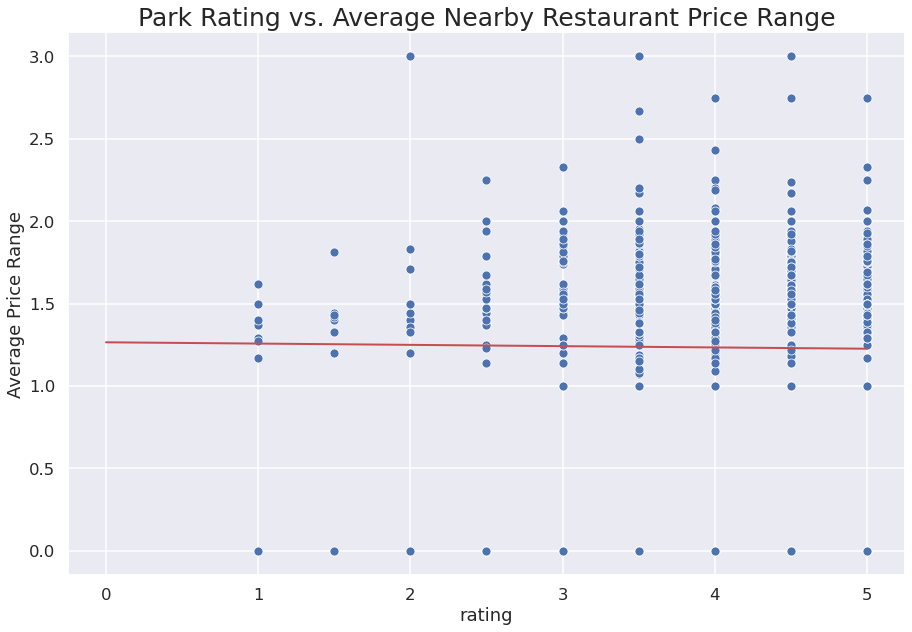

In [12]:
fig, ax = plt.subplots(figsize=(15,10))

ax = sns.scatterplot(park_df['rating'], park_df['avg_price_range'])
plt.plot(ratings, pred_rating2, 'r-', linewidth=2)
#plt.xlabel('Park Rating')
plt.ylabel('Average Price Range')
plt.title('Park Rating vs. Average Nearby Restaurant Price Range', fontsize = 25)

Not much here again. It looks very similar to our first plot, so it doesn't seem promising to hope for a correlation between the average price range of restaurants and park ratings. I can check the Pearson value just to be safe.

In [13]:
print('Pearson r-value: ', pearsonr(park_df['avg_price_range'],park_df['rating'])[0])

Pearson r-value:  -0.008482421453630182


As expected from the graph, no strong correlation found. There seems to be a lot of parks with no restaurants nearby though. Let's see if most of these parks with no nearby restaurants have low ratings as I hypothesized. 

Text(0.5, 0, 'Park Rating')

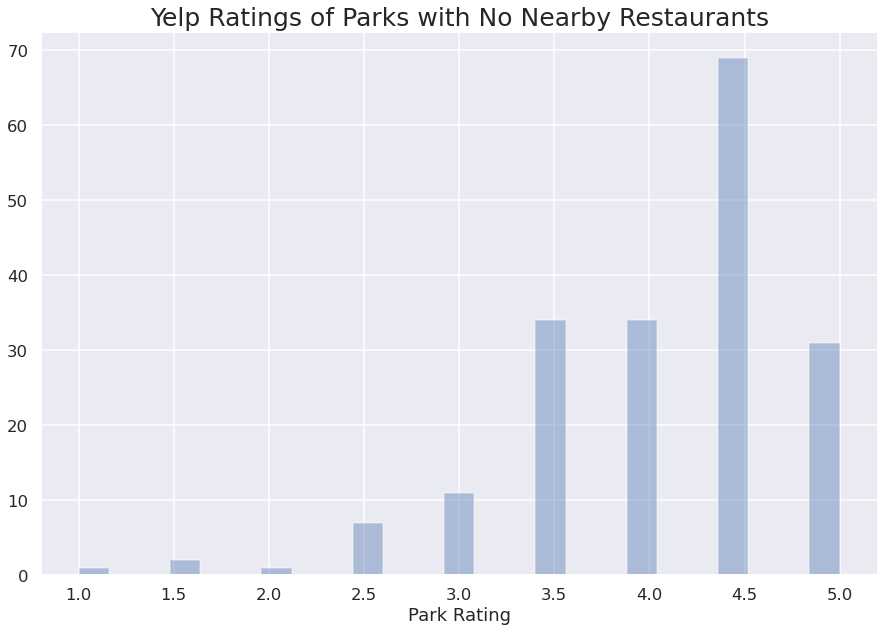

In [14]:
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.distplot(park_df[park_df['avg_restaurant_rating'] == 0]['rating'], kde=False, bins=25)
plt.title('Yelp Ratings of Parks with No Nearby Restaurants', fontsize=25)
plt.xlabel('Park Rating')



If my hypothesis was correct, we would see that the park ratings would be more towards the lower end of the spectrum since there isn't any nearby food sources which should lower the ratings of parks, but it seems that there is no observable effect on the park ratings even with no restaurants nearby. Just to be sure, I'll see if by removing the parks with no nearby restaurants will have any observable effect on park ratings.  

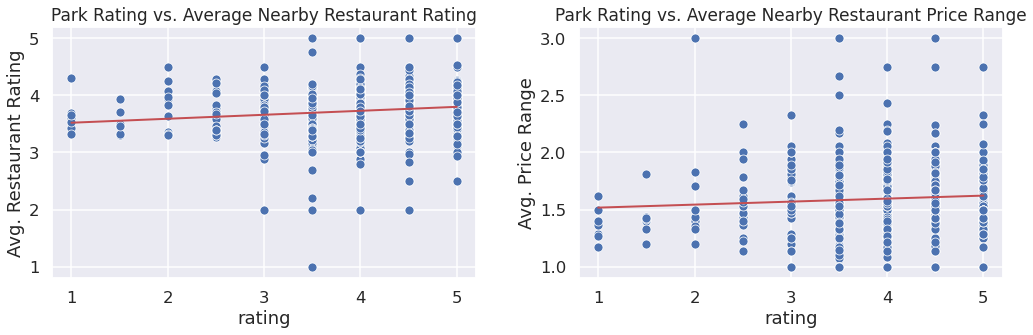

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

df_without_zero = park_df[park_df['avg_price_range'] > 0]

# First plot (Avg. Restaurant Rating vs. Park Rating)
a3, b3 = np.polyfit(df_without_zero['rating'],df_without_zero['avg_restaurant_rating'],1)
ratings2 = np.arange(1,5.5,0.5)
pred_rating3 = a3 * ratings2 + b3

plt.subplot(1,2,1)

# Plot the best-fitting model line
plt.plot(ratings2, pred_rating3, 'r-', linewidth=2)

sns.scatterplot(df_without_zero['rating'], df_without_zero['avg_restaurant_rating'])
plt.ylabel('Avg. Restaurant Rating')
#plt.xlabel('Park Rating')
plt.title('Park Rating vs. Average Nearby Restaurant Rating', fontsize = 17)


# Second plot (Avg. Price Range vs. Park Rating)
a4, b4 = np.polyfit(df_without_zero['rating'],df_without_zero['avg_price_range'],1)
pred_rating4 = a4 * ratings2 + b4

plt.subplot(1,2,2)

# Plot the best-fitting model line
plt.plot(ratings2, pred_rating4, 'r-', linewidth=2)

sns.scatterplot(df_without_zero['rating'], df_without_zero['avg_price_range'])
plt.ylabel('Avg. Price Range')
#plt.xlabel('Park Rating')
plt.title('Park Rating vs. Average Nearby Restaurant Price Range', fontsize = 17)

fig.tight_layout()

We can kind of see a positive correlation between the two but it's still nothing too strong or obvious. Checking the r-values again to be sure.

In [16]:
print('Pearson r-value for Restaurant Ratings vs. Park Rating: ', pearsonr(df_without_zero['avg_restaurant_rating'],df_without_zero['rating'])[0])

print('Pearson r-value for Price Range vs. Park Rating: ', pearsonr(df_without_zero['avg_price_range'],df_without_zero['rating'])[0])


Pearson r-value for Restaurant Ratings vs. Park Rating:  0.1274511828280476
Pearson r-value for Price Range vs. Park Rating:  0.06354252764188438


Again the r-values for both are very low, but restaurant ratings do have a small, yet negligible positive correlation with park ratings.

# Ethics & Privacy

Even though I use info from Yelp, which can be traced back to its users if I'm not careful, all the data used from Yelp has been anonymized already because I simply use the averages of each rating with no personal identifiers saved anywhere in my datasets.  

As for concerns with biases, the reviews themselves could be biased as many restaurants and businesses often offer incentives and free items for a favorable rating on Yelp. There's not much I can do on my end to check for false ratings for the parks or restaurants. Also, because it is hard to even verify users, places can be intentionally rated lower even if the user has never been to the restaurant or park. 

Reviews are also hard to accurately measure quality since usually people who either really love or hate an establishment would be more willing to leave a review. Thus, as with all data science projects, we should always be cautious when looking at the numbers and realize that we didn't come to a 'conclusion', but rather a 'result.' 

# Conclusion & Discussion

After conducting my analysis on nearby restaurant ratings and park ratings, I can conclude that there is no correlation between these two variables.

The scatterplots I generated with its linear regression model line showed no obvious signs of an established relationship between them. In fact, the histogram of all park ratings in San Diego County looks almost identitical to the histogram of parks without nearby restaurants, which means that restaurant access isn't a prioritized feature to consider when rating a park since it had no apparent affect on ratings. The Pearson r-values I calculated before and after removing parks with no nearby restaurants further supported the idea that restaurant ratings have no affect on park ratings because of how small the calculated values were. 

One of the major limitations of this project is the data itself. Yelp ratings can be very biased and misleading. As explained in the 'Ethics & Privacy' section, these ratings can be falsified, which will lead to innaccurate results. Another limitation was dataset size. The list of parks were large but after removing parks with no full data on prices and ratings, I would have nearly a quarter of my original dataset size. Smaller sample sizes are more vulnerable to outliers so I unfortunately had to include them which by sacrificing some missingness in my data. Additionally, the data from Yelp is literally limited in how many API requests I can make per day. If I were to run my program more than 5 times, Yelp would prevent me from getting the data I need. 

Ultimately, while I was disappointed that I was wrong about my hypothesis, I appreciated the process of carrying out a full data science project and truly learned that most of a data scientist's job is wrangling the data.